In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras import models,layers

In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [53]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10
CHANNELS = 3

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle = True,image_size = (IMAGE_SIZE,IMAGE_SIZE),batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [11]:
class_names = dataset.class_names

In [12]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(-0.5, 255.5, 255.5, -0.5)

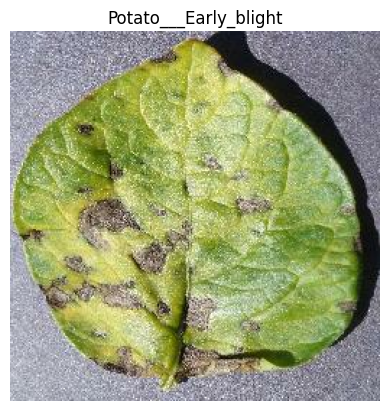

In [25]:
# for image_batch,label_batch in dataset.take(1):
no = np.random.randint(1,32)
plt.title(class_names[label_batch[no]])
plt.imshow(image_batch[no].numpy().astype('uint8'))
plt.axis("off")

In [26]:
len(dataset)

68

In [29]:
train_size = 0.8*len(dataset)
train_dataset = dataset.take(int(train_size))

In [32]:
test_dataset = dataset.skip(int(train_size))
val_size = 0.1*len(test_dataset)
val_dataset = test_dataset.take(int(val_size))

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [34]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [35]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model
Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Modee it

In [36]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [37]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [38]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [45]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [46]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 131s 2s/step - loss: 0.8965 - accuracy: 0.4780 - val_loss: 0.7732 - val_accuracy: 0.5677
Epoch 2/10
54/54 [==============================] - 109s 2s/step - loss: 0.6902 - accuracy: 0.6545 - val_loss: 0.5589 - val_accuracy: 0.7448
Epoch 3/10
54/54 [==============================] - 112s 2s/step - loss: 0.5134 - accuracy: 0.7622 - val_loss: 0.4854 - val_accuracy: 0.8385
Epoch 4/10
54/54 [==============================] - 109s 2s/step - loss: 0.3914 - accuracy: 0.8484 - val_loss: 0.3349 - val_accuracy: 0.8594
Epoch 5/10
54/54 [==============================] - 108s 2s/step - loss: 0.2766 - accuracy: 0.8895 - val_loss: 0.3407 - val_accuracy: 0.8906
Epoch 6/10
54/54 [==============================] - 108s 2s/step - loss: 0.2120 - accuracy: 0.9149 - val_loss: 0.2251 - val_accuracy: 0.9167
Epoch 7/10
54/54 [==============================] - 108s 2s/step - loss: 0.1426 - accuracy: 0.9497 - val_loss: 0.2710 - val_accuracy: 0.9219
Epoch 8/10
54

In [47]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 594ms/step - loss: 0.1371 - accuracy: 0.9609


In [48]:
history.params


{'verbose': 1, 'epochs': 10, 'steps': 54}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

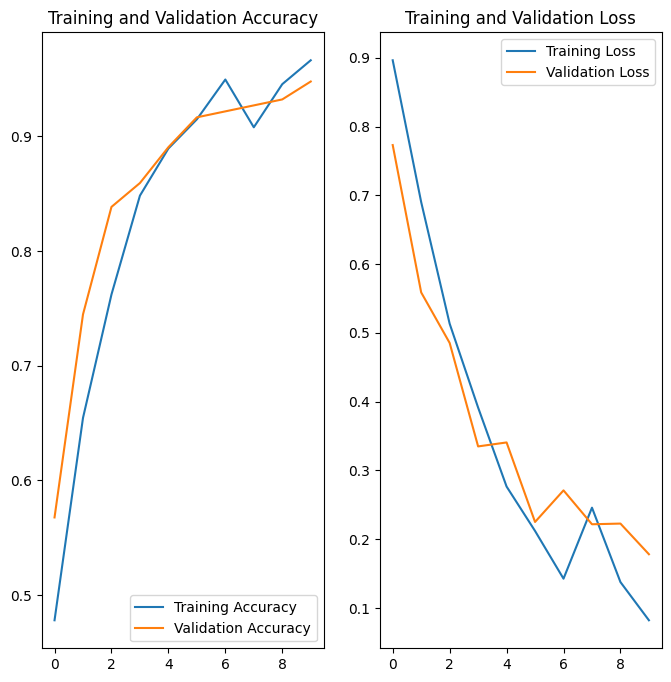

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 919ms/step
predicted label: Potato___Late_blight


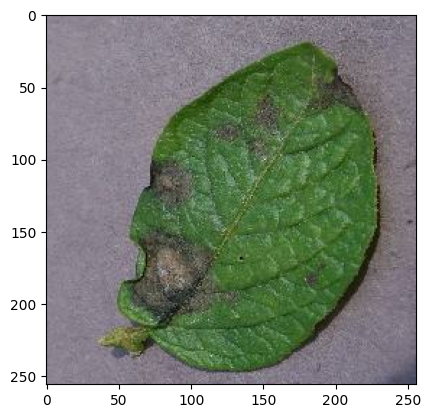

In [56]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [58]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
